<a href="https://colab.research.google.com/github/pinkdolphin11/ESAA/blob/main/HW_1205_CNN_182~211.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 04. 위성 이미지 분류

### 4-1. 텐서플로 데이터셋 로드

* EuroSAT 데이터셋 : 위성 사진 27000장, 토지이용분류값 10개

In [1]:
import tensorflow as tf
import numpy as np
import json
import matplotlib.pylab as plt

#Tensorflow Datasets 활용
import tensorflow_datasets as tfds

In [2]:
#EuroSAT 위성 사진 데이터셋 로드

DATA_DIR = '/content/dataset/'

(train_ds, valid_ds), info = tfds.load('eurosat/rgb', split=['train[:80%]', 'train[80%:]'],
                                       shuffle_files=True,
                                       as_supervised=True, #tuple 형태로 데이터 반환환
                                       with_info=True, #메타 정보 반환 여부부
                                       data_dir=DATA_DIR)
print(train_ds)
print(valid_ds)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27000 [00:00<?, ? examples/s]

Shuffling /content/dataset/eurosat/rgb/2.0.0.incomplete5WSLCC/eurosat-train.tfrecord*...:   0%|          | 0/2…

Dataset eurosat downloaded and prepared to /content/dataset/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.
<PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [3]:
#메타 데이터 확인
print(info)

tfds.core.DatasetInfo(
    name='eurosat',
    full_name='eurosat/rgb/2.0.0',
    description="""
    EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
    bands and consisting of 10 classes with 27000 labeled and
    geo-referenced samples.
    
    Two datasets are offered:
    - rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
    - all: Contains all 13 bands in the original value range (float32).
    
    URL: https://github.com/phelber/eurosat
    """,
    config_description="""
    Sentinel-2 RGB channels
    """,
    homepage='https://github.com/phelber/eurosat',
    data_path='/content/dataset/eurosat/rgb/2.0.0',
    file_format=tfrecord,
    download_size=89.91 MiB,
    dataset_size=89.50 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(64, 64, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervise

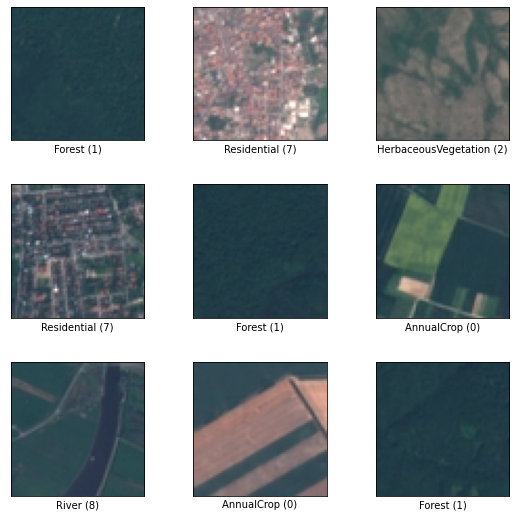

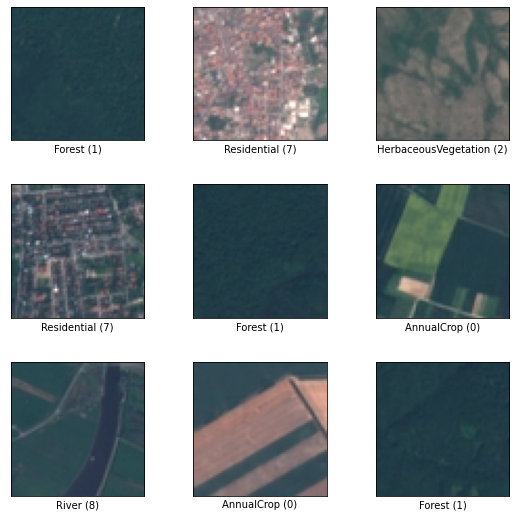

In [4]:
#데이터 확인
tfds.show_examples(train_ds, info)

image  label
0  [[[56, 84, 121], [56, 85, 119], [67, 94, 124],...      5
1  [[[102, 105, 112], [105, 104, 110], [116, 107,...      7
2  [[[82, 98, 97], [83, 97, 97], [86, 97, 99], [9...      0
3  [[[56, 72, 87], [56, 72, 87], [52, 70, 82], [5...      1
4  [[[219, 154, 126], [218, 153, 125], [220, 154,...      0
5  [[[69, 83, 84], [67, 83, 83], [65, 80, 85], [6...      2
6  [[[28, 52, 76], [28, 52, 76], [31, 51, 75], [3...      9
7  [[[45, 75, 77], [46, 74, 78], [49, 69, 78], [6...      8
8  [[[135, 127, 124], [135, 127, 124], [132, 127,...      2
9  [[[40, 55, 74], [40, 55, 74], [41, 56, 75], [3...      9
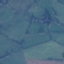
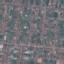
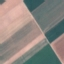
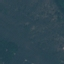
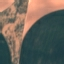
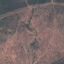
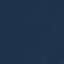
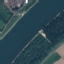
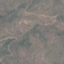
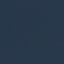

In [5]:
#as_dataframe 사용하여 샘플 출력
tfds.as_dataframe(valid_ds.take(10), info)

In [6]:
#목표 클래스의 개수
NUM_CLASSES = info.features['label'].num_classes
print(NUM_CLASSES)

10


In [7]:
#숫자 레이블을 활용해 문자열 메타 데이터로 변환
print(info.features['label'].int2str(6))

PermanentCrop


### 4-2. 데이터 전처리

* 텐서플로 데이터셋을 사용하면 데이터 전처리에 필요한 함수 제공

* preprocess_data 함수

  * 텐서플로 연산은 cast 함수를 사용하여 자료형을 float32로 변환해 줘야 함

  * 입력 이미지를 255로 나눠서 정규화

* map 함수
  
  * 사용자 정의 함수를 매핑하여 텐서플로 데이터셋에 적용하는 메소드

  * num_parallel_calss 옵션 : AUTOTUNE으로 지정하면 텐서플로 병렬연산 처리를 자동으로 최적화

* 정규화 변환을 마친 데이터셋에 shuffle 메소드를 적용하면 수넛를 랜덤으로 섞음


In [8]:
#데이터 전처리 파이프라인
BATCH_SIZE = 64
BUFFER_SIZE = 1000

def preprocess_data(image, label):
    image = tf.cast(image, tf.float32) / 255. #0~1 정규화, float32 변환
    return image, label

train_data = train_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
valid_data = valid_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)

train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_data = valid_data.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

### 4-3. 모델 훈련 및 검증

In [9]:
#Sequential API를 사용하여 샘플 모델 생성

def build_model():
    
    model = tf.keras.Sequential([

        #Convolution 층
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),

        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),

        #Classifier 출력층
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    return model

model = build_model()

In [10]:
#모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#모델 훈련
history = model.fit(train_data, validation_data=valid_data, epochs=10)

Epoch 1/10
338/338 [==============================] - 205s 603ms/step - loss: 1.6146 - accuracy: 0.4374 - val_loss: 1.5826 - val_accuracy: 0.4776
Epoch 2/10
338/338 [==============================] - 201s 591ms/step - loss: 1.2325 - accuracy: 0.5725 - val_loss: 0.9515 - val_accuracy: 0.6965
Epoch 3/10
338/338 [==============================] - 196s 578ms/step - loss: 1.0393 - accuracy: 0.6300 - val_loss: 0.8260 - val_accuracy: 0.7196
Epoch 4/10
338/338 [==============================] - 211s 624ms/step - loss: 0.9638 - accuracy: 0.6625 - val_loss: 0.7482 - val_accuracy: 0.7531
Epoch 5/10
338/338 [==============================] - 209s 620ms/step - loss: 0.8482 - accuracy: 0.7025 - val_loss: 0.7140 - val_accuracy: 0.7515
Epoch 6/10
338/338 [==============================] - 196s 580ms/step - loss: 0.7893 - accuracy: 0.7288 - val_loss: 0.5475 - val_accuracy: 0.8131
Epoch 7/10
338/338 [==============================] - 171s 507ms/step - loss: 0.7157 - accuracy: 0.7531 - val_loss: 0.5222 -

In [11]:
#모델의 예측 오차와 정확도를 그래프로 그리는 함수
def plot_loss_acc(history, epoch):

    loss, val_loss = history.history['loss'], history.history['val_loss']
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']

    fig, axes = plt.subplots(1, 2, figsize=(12,4))

    axes[0].plot(range(1, epoch+1), loss, label='Training')
    axes[0].plot(range(1, epoch+1), val_loss, label='Validation')
    axes[0].legend(loc='best')
    axes[0].set_title('Loss')

    axes[1].plot(range(1, epoch+1), acc, label='Training')
    axes[1].plot(range(1, epoch+1), val_acc, label='Validation')
    axes[1].legend(loc='best')
    axes[1].set_title('Accuracy')

    plt.show()

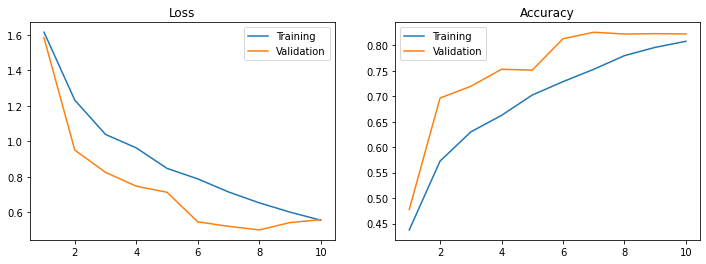

In [12]:
#손실함수, 정확도 그래프 그리기
plot_loss_acc(history, 10)

### 4-4. 데이터 증강(Data Augmentation)

Text(0.5, 1.0, 'Highway')

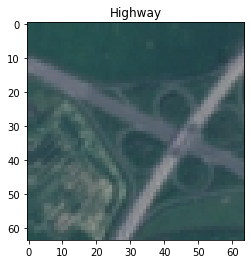

In [13]:
#샘플 이미지
image_batch, label_batch = next(iter(train_data.take(1)))

image = image_batch[0]
label = label_batch[0].numpy()

plt.imshow(image)
plt.title(info.features['label'].int2str(label))

In [14]:
#데이터 증강 전후를 비교하는 시각화 함수를 정의
def plot_augmentation(original, augmented):

    fig, axes = plt.subplots(1, 2, figsize=(12,4))

    axes[0].imshow(original)
    axes[0].set_title('Original')

    axes[1].imshow(augmented)
    axes[1].set_title('Augmented')

    plt.show()

In [15]:
#좌우 뒤집기
lr_flip = tf.image.flip_left_right(image)
plot_augmentation(image, lr_flip)

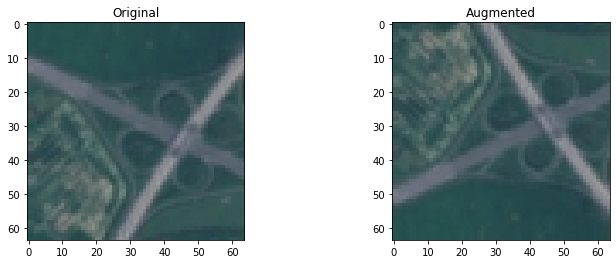

In [16]:
#상하 뒤집기
ud_flip = tf.image.flip_up_down(image)
plot_augmentation(image, ud_flip)

In [17]:
#회전
rotate90 = tf.image.rot90(image)
plot_augmentation(image, rotate90)

In [18]:
#transpose
transpose = tf.image.transpose(image)
plot_augmentation(image, transpose)

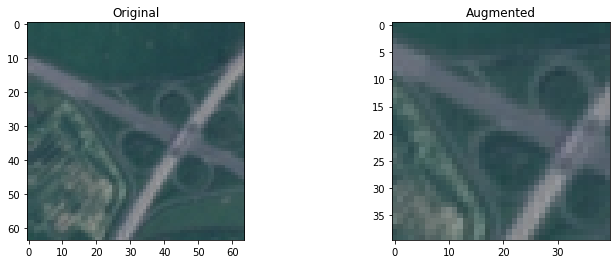

In [19]:
#이미지 자르기 1
crop1 = tf.image.central_crop(image, central_fraction=0.6)
plot_augmentation(image, crop1)

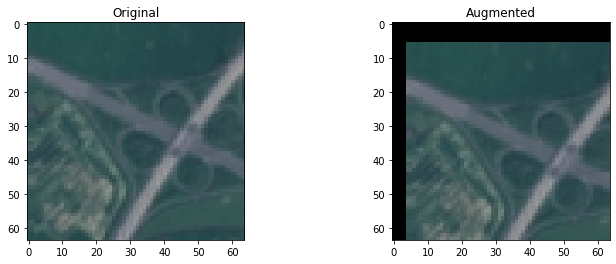

In [20]:
#이미지 자르기 2
img = tf.image.resize_with_crop_or_pad(image, 64 + 20, 64 + 20) #사이즈 키우기
crop2 = tf.image.random_crop(img, size=[64, 64, 3])
plot_augmentation(image, crop2)

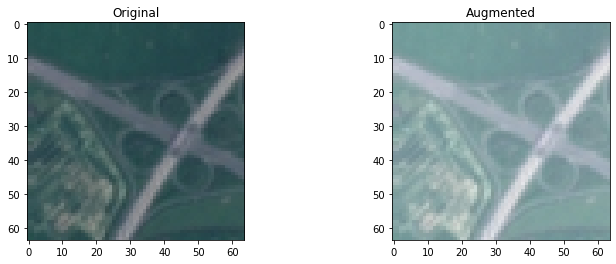

In [21]:
#이미지 밝기
brightness = tf.image.adjust_brightness(image, delta=0.3)
plot_augmentation(image, brightness)

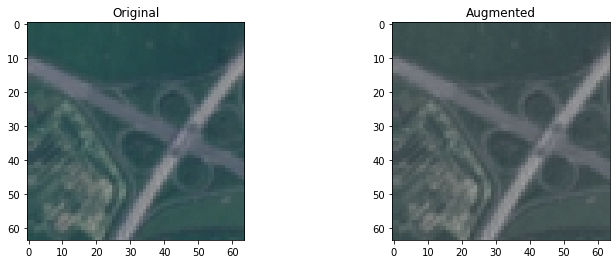

In [22]:
#이미지 채도
saturation = tf.image.adjust_saturation(image, saturation_factor=0.5)
plot_augmentation(image, saturation)

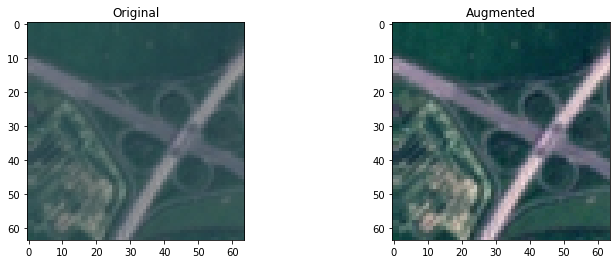

In [23]:
#이미지 대비
contrast = tf.image.adjust_contrast(image, contrast_factor=2)
plot_augmentation(image, contrast)

In [24]:
#이미지 증강 전처리
def data_augmentation(image, label):
    image = tf.image.random_flip_left_right(image) #좌우 반전
    image = tf.image.random_flip_up_down(image) #상하 반전
    image = tf.image.random_brightness(image, max_delta=0.3) #밝기 변화
    image = tf.image.random_crop(image, size=[64, 64, 3])

    image = tf.cast(image, tf.float32) / 255. #0~1 정규화

    return image, label

train_aug = train_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
valid_aug = valid_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

train_aug = train_aug.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_aug = valid_aug.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

print(train_aug)
print(valid_aug)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [25]:
#모델 생성
aug_model = build_model()

#모델 컴파일
aug_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#모델 훈련
aug_history = aug_model.fit(train_aug, validation_data=valid_aug, epochs=10)

Epoch 1/10
338/338 [==============================] - 172s 506ms/step - loss: 1.9211 - accuracy: 0.2838 - val_loss: 1.6406 - val_accuracy: 0.3993
Epoch 2/10
338/338 [==============================] - 168s 498ms/step - loss: 1.6077 - accuracy: 0.3824 - val_loss: 1.4263 - val_accuracy: 0.4807
Epoch 3/10
338/338 [==============================] - 166s 490ms/step - loss: 1.4718 - accuracy: 0.4407 - val_loss: 1.2437 - val_accuracy: 0.5600
Epoch 4/10
338/338 [==============================] - 167s 493ms/step - loss: 1.3592 - accuracy: 0.4924 - val_loss: 1.2533 - val_accuracy: 0.5394
Epoch 5/10
338/338 [==============================] - 164s 485ms/step - loss: 1.2811 - accuracy: 0.5185 - val_loss: 0.9853 - val_accuracy: 0.6548
Epoch 6/10
338/338 [==============================] - 166s 491ms/step - loss: 1.2002 - accuracy: 0.5590 - val_loss: 0.9105 - val_accuracy: 0.7069
Epoch 7/10
338/338 [==============================] - 168s 496ms/step - loss: 1.1640 - accuracy: 0.5733 - val_loss: 0.8974 -

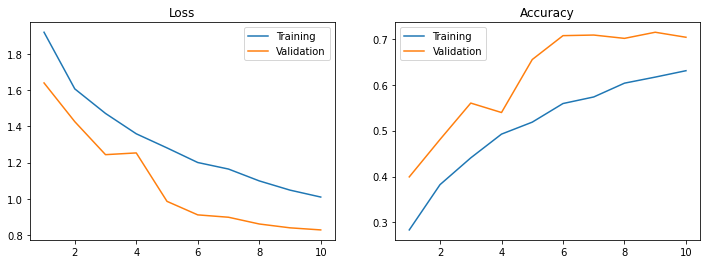

In [26]:
#손실함수, 정확도 그래프 그리기
plot_loss_acc(aug_history, 10)

### 4-5. ResNet 사전 학습 모델

* ResNet 모델 : 이미지넷 경진 대회에서 우승한 모델로서 우수한 성능을 가짐

* 전이 학습(Transfer Learning) : 사전에 방대한 이미지로 훈련받은 딥러닝 모델의 구조와 가중치를 그대로 가져오고, 모델의 끝단에 위치하는 Top 층에 위성 이미지를 분류할 수 있는 최종 분류기 추가

* 케라스에서 모델 인스턴스 직접 불러오기

* include_top = False로 지정하여 Top 층 제거하기

94668760/94668760 [==============================] - 1s 0us/step


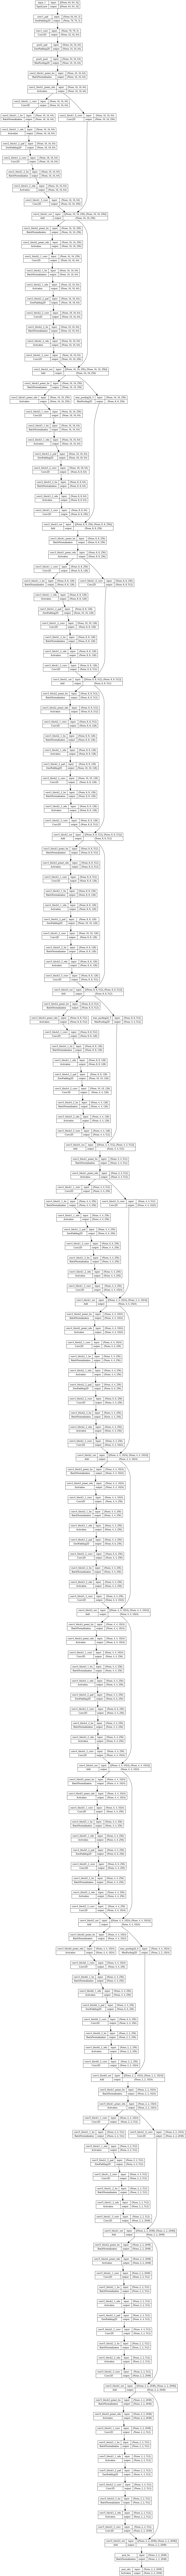

In [27]:
#Pre-trained 모델을 사전 학습된 가중치와 함께 가져오기
from tensorflow.keras.applications import ResNet50V2

pre_trained_base = ResNet50V2(include_top=False,
                              weights='imagenet',
                              input_shape=[64, 64, 3])

#사전 학습된 가중치를 업데이트 되지 않도록 설정
pre_trained_base.trainable = False

#모델 구조 시각화
from tensorflow.keras.utils import plot_model
plot_model(pre_trained_base, show_shapes=True, show_layer_names=True, to_file='resnet50.png')

In [28]:
#Top 층에 Classifier 추가

def build_transfer_classifier():

    model = tf.keras.Sequential([

        #Pre-trained Base
        pre_trained_base,
        #Classifier 출력층
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    return model

#모델 구조
tc_model = build_transfer_classifier()
tc_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_6 (Dense)             (None, 128)               1048704   
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 10)               

## 05. 개/고양이 분류

### 5-1. 분석 준비

In [29]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pylab as plt

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [32]:
# 압축 파일 해제

# 압축 파일의 위치 (구글 드라이브 - 내 드라이브 위치)
drive_path = '/content/drive/MyDrive/'
source_filename = drive_path + 'ESAAdata/cat-and-dog.zip'

# 저장할 경로
extract_folder = 'dataset/'

# 압축 해제
import shutil
shutil.unpack_archive(source_filename, extract_folder)

In [33]:
#훈련 셋, 검증 셋 저장 위치 지정
train_dir = extract_folder + 'training_set/training_set'
valid_dir = extract_folder + 'test_set/test_set'
print(train_dir)
print(valid_dir)

dataset/training_set/training_set
dataset/test_set/test_set


### 5-2. 모델 학습

**5-2-1. ImageDataGenerator**

In [34]:
#이미지 데이터 제너레이터 정의 (Augmentation 미적용)
image_gen = ImageDataGenerator(rescale=(1/255.)) # 정규화
image_gen

**5-2-2. flow_from_directory 함수**

* 이미지 제너레이터 객체에 적용하면 지정한 폴더에서 이미지를 가져와 반복 이터레이션이 가능하도록 데이터셋 처리

In [35]:
#flow_from_directory 함수로 폴더에서 이미지를 가져와 제너레이터 객체로 정리
train_gen = image_gen.flow_from_directory(train_dir,
                                          batch_size=32,
                                          target_size=(224,224),
                                          classes=['cats','dogs'],
                                          class_mode='binary',
                                          seed=2020)

valid_gen = image_gen.flow_from_directory(valid_dir,
                                          batch_size=32,
                                          target_size=(224,224),
                                          classes=['cats','dogs'],
                                          class_mode='binary',
                                          seed=2020)

Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


<ipython-input-36-4563b77d6986>:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.title(class_labels[labels[i].astype(np.int)])


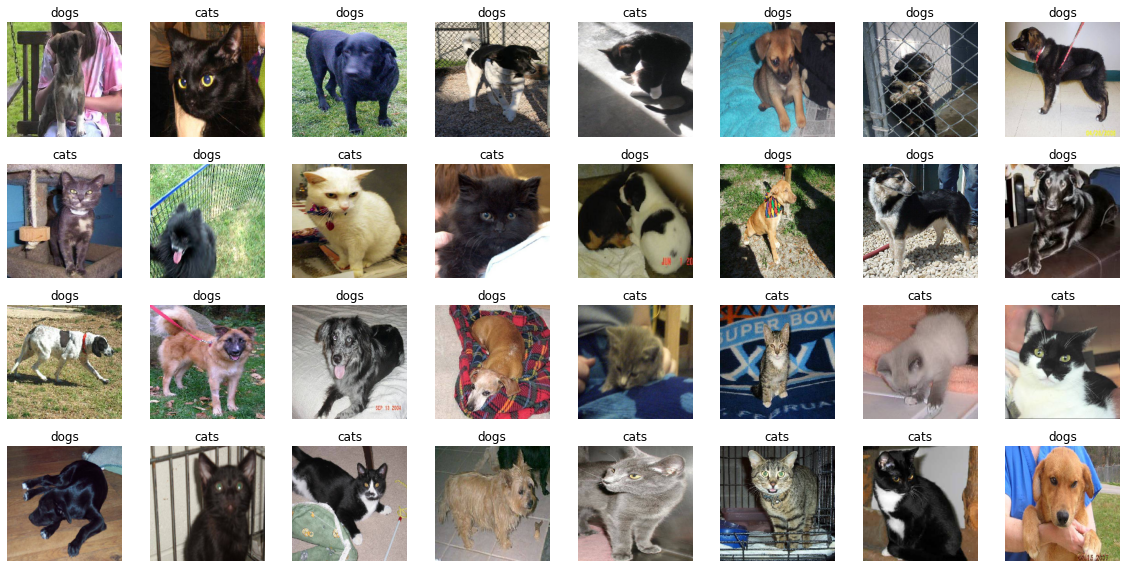

In [36]:
#샘플 이미지 출력
class_labels = ['cats','dogs']
batch = next(train_gen)
images, labels = batch[0], batch[1]

plt.figure(figsize=(16,8))
for i in range(32):

    ax = plt.subplot(4, 8, i+1)
    plt.imshow(images[i])
    plt.title(class_labels[labels[i].astype(np.int)])
    plt.axis('off')

plt.tight_layout()
plt.show()

**5-2-3. 모델 훈련**

In [37]:
#Sequential API를 사용하여 샘플 모델 생성

def build_model():

    model = tf.keras.Sequential([

        #Convolution 층
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),

        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),

        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),

        #Classifier 출력층
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')        
    ])

    return model

model = build_model()

In [ ]:
#모델 컴파일
model.compile(optimizer=tf.optimizers.Adam(lr=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

#모델 훈련
history = model.fit(train_gen, validation_data=valid_gen, epochs=5)

In [ ]:
#손실함수, 정확도 그래프 그리기
plot_loss_acc(aug_history, 10)

**5-2-4. 데이터 증강**

In [ ]:
#이미지 데이터 제너레이터 정의 (Augmentation 적용)
image_gen_aug = ImageDataGenerator(rescale=1/255.,
                                   horizontal_flip=True, #좌우 방향
                                   rotation_range=30, #회전 최대 각도
                                   shear_range=0.15, #반시계 방향으로 밀리도록 변형
                                   zoom_range=0.3) #줌으로 확대

#flow_from_directory 함수로 폴더에서 이미지 가져와서 제너레이터 객체러 정리
train_gen_aug = image_gen_aug.flow_from_directory(train_dir,
                                                  batch_size=32,
                                                  target_size=(224,224),
                                                  classes=['cats','dogs'],
                                                  class_mode='binary',
                                                  seed=2020)

valid_gen_aug = image_gen_aug.flow_from_directory(valid_dir,
                                                  batch_size=32,
                                                  target_size=(224,224),
                                                  classes=['cats','dogs'],
                                                  class_mode='binary',
                                                  seed=2020)

#모델 생성
model_aug = build_model()

#모델 컴파일
model_aug.compile(optimizer=tf.optimizers.Adam(lr=0.001),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])

#모델 훈련
history_aug = model_aug.fit(train_gen_aug, validation_data=valid_gen_aug, epochs=5)

In [ ]:
#손실함수, 정확도 그래프 그리기
plot_loss_acc(aug_history, 10)